# **Chess Upsets Amongst Bots**

**Name: Cameron Andrews**

**Introduction:**

This aim of this project is to explore an interesting phenomenon within the world of chess, yet it will not focus on any human chess players. Instead this project will focus on chess matches between two opposing chess engines, of different and randomly selected ELO ratings.

At first you may believe that the chess engine with a higher ELO rating would always win, simply because chess is known to be a game of perfect information, and therefore the more skilled engine should win against a lesser skilled engine every time. However, by simulating thousands of games under these circumstances, it is noticeable that this is not the case, and that even when there is a large discrepancy amongst the two ELOs, an upset is still possible. This project will aim to analyze the occurrence of upsets between chess engines, determine whether there may be telling signs of when an upset is possible, and attempt to train a model that can determine who is more likely to win given a board position.

But first, we must gather the data!

**Important Note Regarding Project Dependencies:**

During the creation of this notebook I came to the conclusion that I needed a way to significantly increase the speed of my data processing, especially since some points of this tutorial deal with over a million rows at once. Thus I have decided to utilize the RAPIDS toolkit, which allows me to utilize many of the popular Python data science libraries, but with GPU support. In my personal machine I have a NVIDIA 3080 Ti GPU, and wanted to see if I could harness its power to help speed up runtime. However, if you are without a GPU, this project can use a CPU instead, albeit it will run slower.

RAPIDS: https://rapids.ai/

So when you see "cudf" in this project, that is referring to the RAPIDS version of Pandas. It is functionally almost entirely the same but instead uses GPU compute power instead of CPU. This also helps later in the project when I train an XGBoost classifier, again with GPU enabled support.

This also means that this notebook requires a Linux environment to run. This is because the RAPIDS toolkit is currently only supported on Linux. I personally have a Windows machine, and utilized WSL2 (Windows Subsystem for Linux) to develop and run this notebook. I would recommend checking it out if interested @ https://docs.microsoft.com/en-us/windows/wsl/install.

**Data Creation:**

This project will utilize a famous chess engine called "Stockfish", and in the process we will create two different engines; one to play the white pieces, and one for the black pieces. At the beginning of each simulation we will randomly select an ELO rating between 200 and 2500 for each engine. For reference, the highest ranked human chess player in the world, Magnus Carlsen, currently has an ELO floating around 2800.

First, in order to run this script you will need to have access to the Stockfish executable (Downloadable from their website @ https://stockfishchess.org/download). After downloading, you will need to specify the executable path as seen in the code below.

After that you should be able to run this script and generate your own chess data to analyze. However, this script takes several hours to run, and therefore the script will first check to see whether this data has already been created, and if found, will use that instead. Because the resulting CSV file is large (around 500mb), I have decided to split up the CSV into 5 smaller files, that way they can be uploaded to the Github repository and anyone interested in analyzing this data won't have to wait for hours to have fun analyzing!

In [102]:
import chess
import pandas
import numpy as np
import glob
import cudf
from itertools import product
import matplotlib.pyplot as plt
from stockfish import Stockfish
from io import StringIO

preexisting_data_files = glob.glob('Data/chess_data_*.csv', recursive=True)

if len(preexisting_data_files) == 0:

    # Set the number of simulations to run.
    NUM_SIMS = 50000
    chess_df = pandas.DataFrame(columns=[
                                "FEN", "MOVES_DF", "NUM_MOVE_PAIRS", "RESULT", "WINNER", "WHITE_ELO", "BLACK_ELO", "UPSET"])

    for i in range(NUM_SIMS):

        # Configure Two StockFish Chess Engines of unique ELO ratings that will fight eachother
        white_stockfish = Stockfish(
            "stockfish_14.1_win_x64_avx2/stockfish_14.1_win_x64_avx2.exe")
        white_elo = int(np.random.uniform(200, 2500))
        white_stockfish.set_elo_rating(white_elo)

        black_stockfish = Stockfish(
            "stockfish_14.1_win_x64_avx2/stockfish_14.1_win_x64_avx2.exe")
        black_elo = int(np.random.uniform(200, 2500))
        black_stockfish.set_elo_rating(black_elo)

        # Initializing a new chess board
        board = chess.Board()

        # Creating a new DataFrame to Keep track of all moves in the game
        moves_df = pandas.DataFrame(
            columns=["FEN_BEFORE_MOVE", "MOVE_MADE", "TURN"])

        # Making moves until the game ends
        while not board.is_game_over():
            white_stockfish.set_fen_position(board.fen())
            white_next_move = white_stockfish.get_best_move()

            # Appending the current move to a separate DataFrame that tracks all moves made throughout a game
            moves_df = moves_df.append({"FEN_BEFORE_MOVE": board.fen(
            ), "TURN": "WHITE", "MOVE_MADE": white_next_move}, ignore_index=True)
            board.push_uci(white_stockfish.get_best_move())

            black_stockfish.set_fen_position(board.fen())
            black_next_move = black_stockfish.get_best_move()

            # Must check if the game is already over before proceeding
            if black_next_move is not None:
                # Appending the current move to a separate DataFrame that tracks all moves made throughout a game
                moves_df = moves_df.append({"FEN_BEFORE_MOVE": board.fen(
                ), "TURN": "BLACK", "MOVE_MADE": black_next_move}, ignore_index=True)
                board.push_uci(black_next_move)

        # Cleaning the string containing the game's outcome
        result = str(board.outcome(claim_draw=True).termination).replace(
            "Termination.", "")

        # Checks the results of the game and sets a few different variables accordingly
        if result == "CHECKMATE":

            upset = False

            if board.outcome(claim_draw=True).winner == True:
                winner = "WHITE"

                if white_elo < black_elo:
                    upset = True
            else:
                winner = "BLACK"

                if black_elo < white_elo:
                    upset = True
        else:
            winner = None
            upset = "N/A"

        # Adds the game data to the main chess_df DataFrame
        chess_df = chess_df.append(
            {"FEN": board.fen(), "MOVES_DF": moves_df.to_csv(), "NUM_MOVE_PAIRS": board.fullmove_number, "RESULT": result,
             "WINNER": winner, "WHITE_ELO": white_elo, "BLACK_ELO": black_elo, "UPSET": upset}, ignore_index=True)

    # Writes the DataFrame to a CSV file
    chess_df_1 = chess_df.iloc[:10000]
    chess_df_2 = chess_df.iloc[10000:20000]
    chess_df_3 = chess_df.iloc[20000:30000]
    chess_df_4 = chess_df.iloc[30000:40000]
    chess_df_5 = chess_df.iloc[40000:50000]

    chess_df_1.to_csv("Data/chess_data_1.csv")
    chess_df_2.to_csv("Data/chess_data_2.csv")
    chess_df_3.to_csv("Data/chess_data_3.csv")
    chess_df_4.to_csv("Data/chess_data_4.csv")
    chess_df_5.to_csv("Data/chess_data_5.csv")

else:

    chess_df = cudf.DataFrame()

    for file_path in preexisting_data_files:
        # Reading preexisting moves generated from an earlier simulation
        temp_df = cudf.read_csv(file_path)
        temp_df = temp_df.iloc[:, 1:]
        chess_df = cudf.concat([chess_df, temp_df], ignore_index=True)

    # Dropping the index column as it is repetitive
    chess_df = chess_df.iloc[:, 1:]

# Outputting the DataFrame
chess_df


,FEN,MOVES_DF,NUM_MOVE_PAIRS,RESULT,WINNER,WHITE_ELO,BLACK_ELO,UPSET
0,2k1r3/Qb6/1p5p/2p4P/2P5/2B5/P2Pp3/R3Kq2 w - - ...,",FEN_BEFORE_MOVE,MOVE_MADE,TURN\r\n0,rnbqkbnr/...",40,CHECKMATE,BLACK,903,549,True
1,2rqk2r/1p1b2p1/pn2pbQ1/3p1n1p/5P1P/BPp2N1N/P1P...,",FEN_BEFORE_MOVE,MOVE_MADE,TURN\r\n0,rnbqkbnr/...",27,CHECKMATE,WHITE,2417,2137,False
2,2R5/5k1R/8/2K2P1P/2P5/2B5/8/b7 b - - 1 63,",FEN_BEFORE_MOVE,MOVE_MADE,TURN\r\n0,rnbqkbnr/...",63,CHECKMATE,WHITE,1408,233,False
3,r1b4r/ppb1pQk1/3qn1Bp/2p4P/5PP1/2P1N3/PP3R2/R1...,",FEN_BEFORE_MOVE,MOVE_MADE,TURN\r\n0,rnbqkbnr/...",21,CHECKMATE,WHITE,2420,316,False
4,7Q/8/7k/3K1Q2/3P3B/8/8/8 b - - 4 91,",FEN_BEFORE_MOVE,MOVE_MADE,TURN\r\n0,rnbqkbnr/...",91,CHECKMATE,WHITE,1360,2382,True
...,...,...,...,...,...,...,...,...
49995,5k2/5Q2/3P3p/p7/1qNB4/8/6PP/5R1K b - - 0 57,",FEN_BEFORE_MOVE,MOVE_MADE,TURN\r\n0,rnbqkbnr/...",57,CHECKMATE,WHITE,2062,1690,False
49996,3Q1k2/5p1p/1r2b2P/4P3/4P3/2r2PK1/8/8 b - - 1 43,",FEN_BEFORE_MOVE,MOVE_MADE,TURN\r\n0,rnbqkbnr/...",43,CHECKMATE,WHITE,2132,267,False
49997,5Q1R/7n/5p1k/5Pp1/6KP/8/8/8 b - - 4 63,",FEN_BEFORE_MOVE,MOVE_MADE,TURN\r\n0,rnbqkbnr/...",63,CHECKMATE,WHITE,1308,2206,True
49998,8/2p1k3/1b6/n3p2P/4P3/3P1bP1/6qK/8 w - - 0 51,",FEN_BEFORE_MOVE,MOVE_MADE,TURN\r\n0,rnbqkbnr/...",51,CHECKMATE,BLACK,1097,1727,False


**FEN Example**

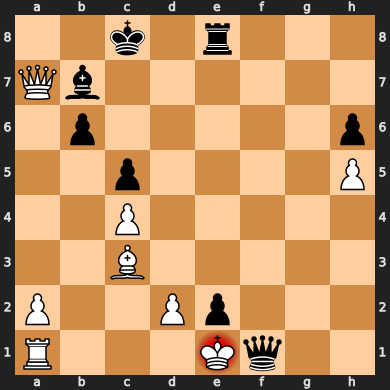

In [103]:
# Outputting a FEN as a chess board. This represents a board position at the end of a simulated match.
fen, moves_df, num_move_pairs, result, winner, white_elo, black_elo, upset = chess_df.to_pandas().values[0]

board = chess.Board(fen)
board

**What Now?**

After that first cell has completed running, you should now be in possession of a Pandas DataFrame containing the results of 50,000 simulated chess matches. The DataFrame has 8 columns in total, with the first being the FEN (Forsyth–Edwards Notation, a standard way for describing board position) at the end of the game. The next column contains a CSV string representing all the individual moves made during that particular game. Now after running 50,000 simulations, we will have roughly over 6,000,000 moves to analyze. The DataFrame also contains a count of move pairs made during the match, the match result, winner, ELO rankings, and a boolean column describing whether the match ended in an upset, where the lower ranked engine beat the higher ranked.

So now that we have a Pandas DataFrame containing the results of our simulation, we can begin to explore the data and determine whether there are any common traits amongst games that ended in an upset.

In [104]:
print("Ratio of Total Games that Ended in an Upset:")
print("Ended in Upset:", chess_df["UPSET"].value_counts()[0])
print("Didn't End in Upset:", chess_df["UPSET"].value_counts()[1], "\n")
percentage = round((chess_df["UPSET"].value_counts()[1] / len(chess_df)) * 100, 3)
print(f"Percentage of Total Games that Ended in Upset: {percentage} %")


Ratio of Total Games that Ended in an Upset:
Ended in Upset: 31286
Didn't End in Upset: 16822 

Percentage of Total Games that Ended in Upset: 33.644 %


Clearly it appears that a fairly significant number of games end up in an upset, and in my testing it also seems that the percentage of upsets remains around 33% regardless of the number of simulations ran.

**Plotting:**

At this point I have a variety of different hypotheses concerning the likeliness of a chess upset, so I am going to go ahead and visualize some of our data to see if there's any truth to my ideas. To do this, I will create histogram plots of both the differences amongst ELO ratings of opponents, as well as the total distribution of ELO rankings to see if it is truly uniform. I will also go ahead and plot two histograms representing the distribution of game lengths amongst upsets only, as well as the total distribution of upsets.

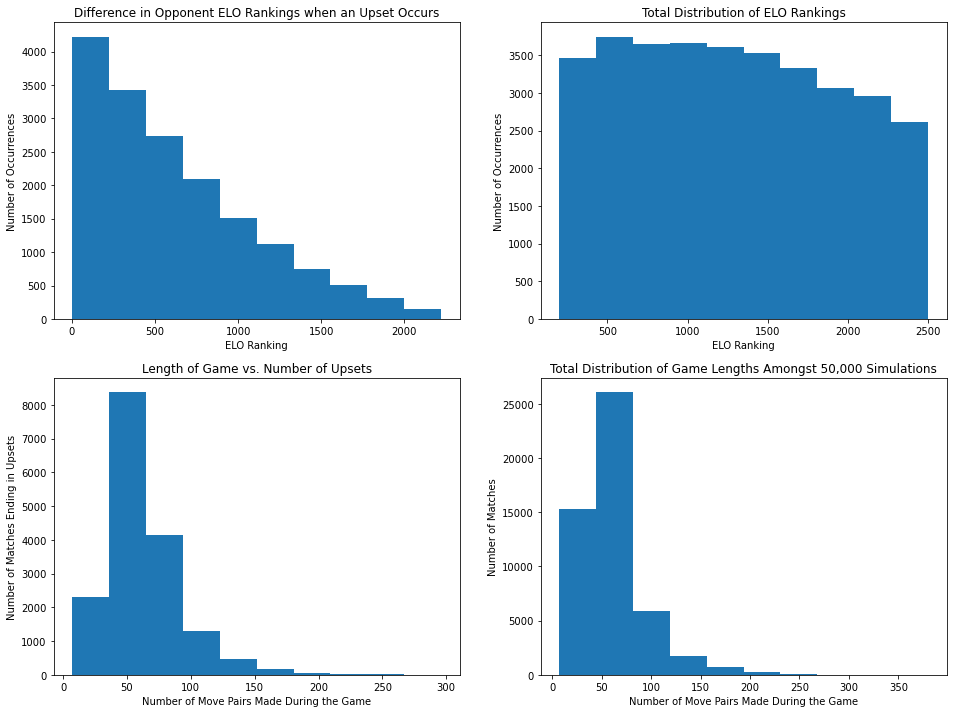

In [105]:
# Filtering the pandas dataframe to only see games that ended in an upset
chess_upsets_df = chess_df.query("UPSET == True")

# Two lists that will hold total ELO rankings, as well as the difference between ELO amongst opponents
elo_rankings = np.append(chess_upsets_df["WHITE_ELO"].to_numpy(), chess_upsets_df["BLACK_ELO"].to_numpy())
differences = abs(chess_upsets_df["WHITE_ELO"].to_numpy() - chess_upsets_df["BLACK_ELO"].to_numpy())
number_of_move_pairs_upsets = chess_upsets_df["NUM_MOVE_PAIRS"].to_arrow().to_pylist()
number_of_move_pairs = chess_df["NUM_MOVE_PAIRS"].to_arrow().to_pylist()

# Configuring multiple histogram plots to display the distribution of ELO rankings and differences
fig, axs = plt.subplots(2, 2, sharey=False, tight_layout=False)
fig.set_figwidth(16)
fig.set_figheight(12)

# Histogram of differences between opponent ELOs in Upsets
axs[0][0].hist(differences)
axs[0][0].set_title("Difference in Opponent ELO Rankings when an Upset Occurs")
axs[0][0].set_xlabel("ELO Ranking")
axs[0][0].set_ylabel("Number of Occurrences")

# Histogram of total distribution of ELO rankings
axs[0][1].hist(elo_rankings)
axs[0][1].set_title("Total Distribution of ELO Rankings")
axs[0][1].set_xlabel("ELO Ranking")
axs[0][1].set_ylabel("Number of Occurrences")

# Histogram of game lengths in Upsets
axs[1][0].hist(number_of_move_pairs_upsets)
axs[1][0].set_title("Length of Game vs. Number of Upsets")
axs[1][0].set_xlabel("Number of Move Pairs Made During the Game")
axs[1][0].set_ylabel("Number of Matches Ending in Upsets")

# Histogram of total game lengths
axs[1][1].hist(number_of_move_pairs)
axs[1][1].set_title(
    "Total Distribution of Game Lengths Amongst 50,000 Simulations")
axs[1][1].set_xlabel("Number of Move Pairs Made During the Game")
axs[1][1].set_ylabel("Number of Matches")


plt.show()


Based on the plots above, we can confirm that ELO rankings are *mostly* drawn from a uniform distribution as we specified earlier. But what else is interesting is that it seems the number of upsets decreases exponentially with a larger difference in the ELO rankings of opponents. This makes sense as it is surely more likely that an upset would occur between closely ranked opponents, but nonetheless it can still happen even with differences larger than 2000! The bottom row of charts also helps see if there is a possible correlation between the length of a game and the chances of it becoming an upset. However, as we can see it seems that the distribution of game lengths amongst upsets appears roughly similar to the overall distribution of game lengths, meaning that there does not appear to be a strong correlation between how long a game lasts and whether it will end in an upset.

This also means that there must be some other reason that a chess game can end up in an upset!

Is it that the lower ranked engine produces more randomized moves that aren't easily predictable? Or perhaps there's always a chance that the higher skilled engine can make an irreversible blunder?

**Piece Possession**

Perhaps we can explore the distribution of pieces by the end of a match to see if there is a clear pattern amongst pieces that underdogs obtain at the end of upsets versus their opponents.

In [106]:
winner_queens, winner_kings, winner_knights, winner_bishops, winner_rooks, winner_pawns = [], [], [], [], [], []
loser_queens, loser_kings, loser_knights, loser_bishops, loser_rooks, loser_pawns = [
], [], [], [], [], []

for fen, moves_df, num_move_pairs, result, winner, winner_elo, loser_elo, upset in chess_upsets_df.to_pandas().values:

    if winner == "WHITE":
        winner_queens.append(str(fen).split(" ")[0].count("Q"))
        winner_kings.append(str(fen).split(" ")[0].count("K"))
        winner_knights.append(str(fen).split(" ")[0].count("N"))
        winner_bishops.append(str(fen).split(" ")[0].count("B"))
        winner_rooks.append(str(fen).split(" ")[0].count("R"))
        winner_pawns.append(str(fen).split(" ")[0].count("P"))

        loser_queens.append(str(fen).split(" ")[0].count("q"))
        loser_kings.append(str(fen).split(" ")[0].count("k"))
        loser_knights.append(str(fen).split(" ")[0].count("n"))
        loser_bishops.append(str(fen).split(" ")[0].count("b"))
        loser_rooks.append(str(fen).split(" ")[0].count("r"))
        loser_pawns.append(str(fen).split(" ")[0].count("p"))

    else:
        loser_queens.append(str(fen).split(" ")[0].count("Q"))
        loser_kings.append(str(fen).split(" ")[0].count("K"))
        loser_knights.append(str(fen).split(" ")[0].count("N"))
        loser_bishops.append(str(fen).split(" ")[0].count("B"))
        loser_rooks.append(str(fen).split(" ")[0].count("R"))
        loser_pawns.append(str(fen).split(" ")[0].count("P"))

        winner_queens.append(str(fen).split(" ")[0].count("q"))
        winner_kings.append(str(fen).split(" ")[0].count("k"))
        winner_knights.append(str(fen).split(" ")[0].count("n"))
        winner_bishops.append(str(fen).split(" ")[0].count("b"))
        winner_rooks.append(str(fen).split(" ")[0].count("r"))
        winner_pawns.append(str(fen).split(" ")[0].count("p"))

print("Average Number of Pieces Remaining After Upsets:\n")
print("Queens:")
print("\tWinner:", np.average(winner_queens))
print("\tLoser:", np.average(loser_queens))
print("Knights:")
print("\tWinner:", np.average(winner_knights))
print("\tLoser:", np.average(loser_knights))
print("Bishops:")
print("\tWinner:", np.average(winner_bishops))
print("\tLoser:", np.average(loser_bishops))
print("Rooks:")
print("\tWinner:", np.average(winner_rooks))
print("\tLoser:", np.average(loser_rooks))
print("Pawns:")
print("\tWinner:", np.average(winner_pawns))
print("\tLoser:", np.average(loser_pawns))


Average Number of Pieces Remaining After Upsets:

Queens:
	Winner: 0.9168945428605397
	Loser: 0.26078944239686125
Knights:
	Winner: 0.5448817025323981
	Loser: 0.32350493401498037
Bishops:
	Winner: 0.7590060634882891
	Loser: 0.44958982285102844
Rooks:
	Winner: 1.158066817263108
	Loser: 0.65985019617168
Pawns:
	Winner: 3.2245868505528477
	Loser: 2.69884674830579


**Decision Tree Time!**

This section will focus on one method of discovering possible common attributes amongst upsets, and will look to build a model that can output a value representative of who is more likely to win a game at any given board position. Its inputs will include 64 columns representing the current board position. But first we must create a DataFrame of all our board positions, in a way that a model could understand.

Similar to the beginning of this tutorial, there is some functionality to verify whether the CSV file already exists, and will insist on using that one instead if found.

In [107]:
# Attempts to find the CSV file in question
preexisting_data_files = glob.glob('Data/chess_moves_upsets_df.csv', recursive=True)

# Checks to see if any files were found
if len(preexisting_data_files) == 0:

    # New cudf DataFrame to hold board position
    chess_moves_upsets_df = cudf.DataFrame()

    chess_upsets_df["WINNER_NUM"] = chess_upsets_df["WINNER"].map({"WHITE": 1, "BLACK": -1})

    for fen, moves_df, num_move_pairs, white_elo, black_elo, winner_num in zip(chess_upsets_df["FEN"].to_numpy(), chess_upsets_df["MOVES_DF"].to_numpy(), chess_upsets_df["NUM_MOVE_PAIRS"].to_numpy(), 
                                                                            chess_upsets_df["WHITE_ELO"].to_numpy(), chess_upsets_df["BLACK_ELO"].to_numpy(), chess_upsets_df["WINNER_NUM"].to_numpy()):

        # Because we are dealing with a fairly large number of rows, I decided to only grab a snapshot from each game to train off of.
        # Specifically, I take a snapshot that should be representative of the halway point in a particular match
        middle_point = round((num_move_pairs * 2) / 2)
        winning_moves_df = cudf.read_csv(StringIO(moves_df))[middle_point:middle_point + 1]

        # Adding columns for ELO rankings as well as an indicator for the match winner
        winning_moves_df["WHITE_ELO"] = white_elo
        winning_moves_df["BLACK_ELO"] = black_elo
        winning_moves_df["WINNER"] = winner_num

        # Concatenating the current cudf DataFrame and the new one we just created
        chess_moves_upsets_df = cudf.concat([chess_moves_upsets_df, winning_moves_df], ignore_index=True)

    # Dropping the index column as it is repetitive
    chess_moves_upsets_df = chess_moves_upsets_df.iloc[:, 1:]

    # Writing to a CSV file to be restored later
    chess_moves_upsets_df.to_csv("Data/chess_moves_upsets_df.csv")

else:
    # If we already found the CSV file, we will use that one instead
    chess_moves_upsets_df = cudf.read_csv(preexisting_data_files[0])

    # Dropping the index column as it is repetitive
    chess_moves_upsets_df = chess_moves_upsets_df.iloc[:, 1:]


chess_moves_upsets_df


,FEN_BEFORE_MOVE,MOVE_MADE,TURN,WHITE_ELO,BLACK_ELO,WINNER
0,1k1r3r/Nb1qn1b1/1p5p/2p1p1pP/2pP4/1P1B2R1/PB1P...,d4c5,WHITE,903,549,-1
1,8/5p1k/5B1p/1P6/p6p/P2pK3/3P1P2/4R3 b - - 0 46,h7g6,BLACK,1360,2382,1
2,3q3r/5r1p/1pB2kp1/pPb2p2/P2p3P/4n1P1/7K/R2Q1R2...,d1d3,WHITE,1494,277,-1
3,3r1rk1/2Bb2pp/ppn1p1q1/5p2/PPpb4/5BP1/4QP1P/1R...,c7d8,WHITE,1103,383,-1
4,3r1k2/5p2/1p1N4/6p1/3R4/P2N1K2/1P6/8 b - - 7 39,b6b5,BLACK,674,1125,1
...,...,...,...,...,...,...
16817,r5k1/1q5p/b3p1p1/4br2/4N1QN/3nR2P/P5P1/3R3K b ...,b7g7,BLACK,1170,569,-1
16818,5rk1/2qb1ppp/4pb2/8/R2P1P2/3P4/1P3PBP/3Q1RK1 w...,a4c4,WHITE,1442,1031,-1
16819,r3k2r/1b4pp/p1q2n1B/3pp3/1b1P1N1P/2NB3R/1PP2PP...,e5e4,BLACK,931,1064,1
16820,r5k1/1r3ppn/4p3/2Q3p1/4P1P1/5P2/7P/2B2RK1 b - ...,g7g6,BLACK,1308,2206,1


**Splitting the FENs!**

In order to create a DataFrame that could be used for training a model, we must find a way to represent a FEN numerically, and in separate columns. Thus we will no iterate through the cudf DataFrame we just created, and split each FEN into a list of 64 elements, with each element representing a square on a chess board. As we do this, we are also assigning numeric values to chess pieces. For example, an empty square will be represented by a 0, but a Queen will be represented by a 9. These mappings from pieces to values is in accordance with the standardized notation for piece value, with the exception of Bishops, which have been given a value of 3.15 instead of 3. This is to help differentiate between knights and bishops.

An important note here is that White pieces are assigned positive values, and Black pieces are assigned negative values.

In [108]:
# Attempts to find the CSV file in question
preexisting_data_files = glob.glob('Data/ml_df.csv', recursive=True)

# Checks to see if any files were found
if len(preexisting_data_files) == 0:

    # Dictionary containing mappings of pieces to numerical values.
    piece_map = {"K": 1000000, "Q": 9, "N": 3, "B": 3.15, "R": 5, "P": 1,
                "k": -1000000, "q": -9, "n": -3, "b": -3.15, "r": -5, "p": -1}

    # This creates the list of columns by finding the cartesian product of two lists, columns and rows.
    columns_combo = list(product(["A", "B", "C", "D", "E", "F", "G", "H"], ["1", "2", "3", "4", "5", "6", "7", "8"]))
    columns = [a + b for a, b in columns_combo]

    # Adds extra columns for ELO rankings and Winner
    columns.append("WHITE_ELO")
    columns.append("BLACK_ELO")
    columns.append("WINNER")

    # Creates a new cudf DataFrame with the columns created above
    ml_df = cudf.DataFrame(columns=columns)

    # Iterates through multiple cudf series simultaneously using the zip function
    for fen, white_elo, black_elo, winner_num in zip(chess_moves_upsets_df["FEN_BEFORE_MOVE"].to_numpy(), chess_moves_upsets_df["WHITE_ELO"].to_numpy(), \
                                                    chess_moves_upsets_df["BLACK_ELO"].to_numpy(), chess_moves_upsets_df["WINNER"].to_numpy()):
                                                    

        # Converting the FEN into a string with no spaces or slashes
        squares = str(fen.split(" ")[0]).replace("/", "")

        new_row = {}
        col_index = 0

        # iterates through characters of the FEN and adds them to the new row
        for square in squares:
            try:
                for i in range(int(square)):
                    new_row.update({columns[col_index]:0})
                    col_index += 1

            except ValueError:
                new_row.update({columns[col_index]:piece_map[square]})
                col_index += 1

        new_row.update({"WHITE_ELO":white_elo})
        new_row.update({"BLACK_ELO":black_elo})
        new_row.update({"WINNER":winner_num})


        # Adds the newly created row to our cudf DataFrame
        ml_df = ml_df.append(new_row, ignore_index=True)

    # Writing to a CSV file to be restored later
    ml_df.to_csv("Data/ml_df.csv")

else:
    # If we already found the CSV file, we will use that one instead
    ml_df = cudf.read_csv(preexisting_data_files[0])

    # Dropping the index column as it is repetitive
    ml_df = ml_df.iloc[:, 1:]

# Dropping the ELO columns because they essentially are the only ones that will matter in decision making otherwise
ml_df = ml_df.drop(columns=["WHITE_ELO", "BLACK_ELO"])

# Mapping the values in the winner column to values that XGBoost can understand.
ml_df["WINNER"] = ml_df["WINNER"].map({1:1, -1:0})
ml_df

,A1,A2,A3,A4,A5,A6,A7,A8,B1,B2,...,G8,H1,H2,H3,H4,H5,H6,H7,H8,WINNER
0,0.0,-1000000.0,0.0,-5.0,0.0,0.00,0.0,-5.0,3.0,-3.15,...,3.0,5.0,0.0,0.00,9.0,1000000.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.00,0.0,5.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,-9.0,0.0,0.00,0.0,-5.0,0.0,0.00,...,1000000.0,5.0,0.0,0.00,9.0,0.0,5.0,0.0,0.0,0
3,0.0,0.0,0.0,-5.0,0.0,-5.00,-1000000.0,0.0,0.0,0.00,...,1.0,0.0,5.0,0.00,0.0,0.0,5.0,1000000.0,0.0,0
4,0.0,0.0,0.0,-5.0,0.0,-1000000.00,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16817,-5.0,0.0,0.0,0.0,0.0,0.00,-1000000.0,0.0,0.0,-9.00,...,0.0,0.0,0.0,0.00,5.0,0.0,0.0,0.0,1000000.0,0
16818,0.0,0.0,0.0,0.0,0.0,-5.00,-1000000.0,0.0,0.0,0.00,...,1.0,0.0,0.0,0.00,9.0,0.0,5.0,1000000.0,0.0,0
16819,-5.0,0.0,0.0,0.0,-1000000.0,0.00,0.0,-5.0,0.0,-3.15,...,0.0,5.0,0.0,0.00,9.0,1000000.0,0.0,0.0,0.0,1
16820,-5.0,0.0,0.0,0.0,0.0,0.00,-1000000.0,0.0,0.0,-5.00,...,1.0,0.0,0.0,3.15,0.0,0.0,5.0,1000000.0,0.0,1


**XGBoost**

And now the fun starts! With XGBoost we are going to build a logistic regressor that will output a probability value. This value will be indicative of the probability of a 1 being the output, given the board position it was fed. In our case, a "1" would be representative of White winning, whereas a 0 would mean that Black will win. So, the higher our output value, the more likely it believes White will end up winning that match, and the lower the value, the less likely it believes White will win, and the more likely it believes Black will win.

I could have also decided to use a different "objective" for XGBoost called "binary:hinge" which outputs only two values (1 or 0), but I think that the regression approach provides more detail and value for our use case, especially since we are only looking at board positions from halfway through matches, and a lot can happen before the match conclusion.

But first we must split up our data into training and testing sets. In addition, we will also create two DMatrix objects from these training and testing sets that will be fed to XGBoost.

In [109]:
# Importing XGBoost as well as a function to help split our training data
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Setting input values to everything but the winner column
X = ml_df.drop(columns=["WINNER"], axis=1)

# Setting target value to the winner column
y = ml_df["WINNER"]

# Splitting the testing data using the function supplied by scikit-learn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Creating the DMatrix objects
dmat_train = xgb.DMatrix(X_train, y_train, feature_names=ml_df.columns.tolist().remove("WINNER"))
dmat_test = xgb.DMatrix(X_test, y_test, feature_names=ml_df.columns.tolist().remove("WINNER"))

dmat_train, dmat_test

/home/cam/miniconda3/envs/rapids-21.12/lib/python3.8/site-packages/cudf/core/frame.py:3077: FutureWarning: keep_index is deprecated and will be removed in the future.
  warnings.warn(


(<xgboost.core.DMatrix at 0x7f985f4b4f10>,
 <xgboost.core.DMatrix at 0x7f985f4b4460>)

The next line is what will create and traing our XGBoost "Booster". It has a couple of parameters, as well as arguments for supplying the DMatrix objects.

The parameters can be set through various experimentation or other tuning methods. I personally have settled on a max tree depth of 9 after a bit of trial and error but feel free to alter that argument to find better results. As mentioned before, the "objective" is set to "binary:logistic".

Let's see how we do!

In [110]:
booster = xgb.train({"max_depth": 6, "objective": "binary:logistic", "tree_method":"hist"}, dmat_train, evals=[(dmat_train, "train"), (dmat_test, "test")])

[15:36:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	train-logloss:0.66668	test-logloss:0.67497
[1]	train-logloss:0.64891	test-logloss:0.66390
[2]	train-logloss:0.63458	test-logloss:0.65773
[3]	train-logloss:0.62482	test-logloss:0.65442
[4]	train-logloss:0.61374	test-logloss:0.65211
[5]	train-logloss:0.60350	test-logloss:0.65053
[6]	train-logloss:0.59620	test-logloss:0.64883
[7]	train-logloss:0.59089	test-logloss:0.64860
[8]	train-logloss:0.58557	test-logloss:0.64776
[9]	train-logloss:0.58076	test-logloss:0.64714


It's a little hard to tell how we're doing strictly from the loss results. Let's compare our output values with the actual targets to see if we can get a better idea of what's going on.

In [111]:
# Outputting a cudf DataFrame with the actual targets and the probabilities our model output
cudf.DataFrame({"Actuals":y_test, "Probability of White Winning":booster.predict(dmat_test)})

,Actuals,Probability of White Winning
10871,1,0.704363
12128,1,0.459750
4766,1,0.654608
11992,1,0.524115
1002,0,0.489311
...,...,...
11689,1,0.680121
2938,0,0.680614
16792,1,0.743475
15956,1,0.525113


Well that's pretty neat! It does seem that our model outputs higher values for games won by White (1), and relatively lower values for games won by Black (0).

We can also visualize the tree to get a better idea of what it looks like.

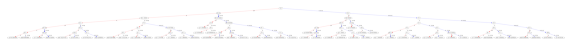

In [112]:
xgb.plot_tree(booster)
fig = plt.gcf()
fig.set_size_inches(10, 20)
fig.savefig('tree.png')

For an applied look at how our model behaves in the real world, I have gathered a FEN from a 2010 match between Magnus Carlsen (ELO: 2810), and Sergey Karjakin (ELO: 2720), and I want to see if the model has a good guess as to who wins the match, based upon the FEN representing a board position roughly halfway through the match.\

White: Sergey Karjakin

Black: Magnus Carlsen

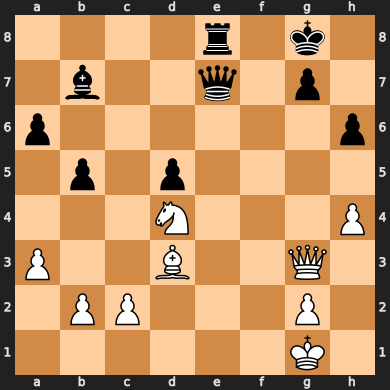

In [113]:
# Fen from the game
fen = "4r1k1/1b2q1p1/p6p/1p1p4/3N3P/P2B2Q1/1PP3P1/6K1 b - h3 0 30"

# Outputting a visual of the board
board = chess.Board(fen)
board

Converting the FEN into a format we can predict from, and running our booster predict function.

In [114]:
# Converting the FEN into a string with no spaces or slashes
squares = str(fen.split(" ")[0]).replace("/", "")

new_row = {}
col_index = 0

# This creates the list of columns by finding the cartesian product of two lists, columns and rows.
columns_combo = list(product(["A", "B", "C", "D", "E", "F", "G", "H"], ["1", "2", "3", "4", "5", "6", "7", "8"]))
columns = [a + b for a, b in columns_combo]

# iterates through characters of the FEN and adds them to the new row
for square in squares:
    try:
        for i in range(int(square)):
            new_row.update({columns[col_index]:0})
            col_index += 1

    except ValueError:
        new_row.update({columns[col_index]:piece_map[square]})
        col_index += 1


# Creating a DataFrame to convert to a DMatrix Object
test_df = cudf.DataFrame(columns=columns)
test_df = test_df.append(new_row, ignore_index=True)

# Creating a DMatrix object for prediction
applied_test = xgb.DMatrix(test_df, [[0]], feature_names=ml_df.columns.tolist().remove("WINNER"))

# Predicting the probability of white winning
predicted_probability = booster.predict(applied_test)[0]

print("Probability of White Winning:", predicted_probability*100, "%")


Probability of White Winning: 45.244017243385315 %


And there you have it! Given the current FEN it predicts that white still has a 45.24% chance of winning despite a pretty gruesome board position. Obviously it is no secret as to why that probability is so high though. Because we have trained our model solely off of games that ended in upsets, it will of course have a bias towards the underdog in a given position. This is definitely an interesting observation and it would be interesting to continue tinkering with various parameters and inputs to see if we can get more accurate results in the future.

However, it does sufficiently recognize that Black is more likely to win, which is what inevitably ends up happening.